In [1]:
import networkx as nx
import pyhocon
import pandas as pd
from sqlalchemy import create_engine
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
def create_mssql_engine(database):
    h = 'ares-migration.database.windows.net'
    d = database
    u = 'ares@ares-migration'
    p = 'ahT9sLc)3e@#'

    pymssql_url = 'mssql+pymssql://{u}:{p}@{h}/{d}?charset=utf8'
    return create_engine(pymssql_url.format(u=u, h=h, p=p, d=d))

In [3]:
from azure.keyvault import KeyVaultClient, KeyVaultAuthentication
from azure.common.credentials import ServicePrincipalCredentials

class KeyVault(object):
    """
    Abstraction for the Azure Key Vaults
    """
    _config = None
    _client_id = ''
    _tenant = ''
    _secret = ''
    _resource = 'https://vault.azure.net'
    _client = None
    _vault = None

    def __init__(self, config):
        """
        :param config: config: pyhocon configuration object
        """
        _config = config
        self._tenant = config.get('azure.tenant')
        self._vault = config.get('azure.vaultid')
        self._client_id = config.get('azure.app')
        self._secret = config.get('azure.client-secret')
        self._client = KeyVaultClient(KeyVaultAuthentication(authorization_callback=self._auth_callback))


    def _auth_callback(self, server, resource, scope,x):
        credentials = ServicePrincipalCredentials(
            client_id= self._client_id,
            secret=self._secret,
            tenant=self._tenant,
            resource=self._resource
        )
        token = credentials.token
        return token['token_type'], token['access_token']

    def fetch_secret(self, secret_id, secret_version):
        """
        Fetch the known client secret from the KeyVault.
        :param secret_id: the secret's name
        :param secret_version: the secrets's version hex
        :return:
        """
        secret_bundle = self._client.get_secret(
            'https://{0}.vault.azure.net/'.format(self._vault),
            secret_id,
            secret_version)
        return secret_bundle

In [4]:
def create_mysql_engine(db):
    azure_cfg_str = """
    {
    azure = {
            tenant: "d5e917df-533c-4bc8-89a0-04a9fb6d3aee"
            app: "bc3f2cd0-05b2-4831-b9f4-72adc921b197"
            client-secret: "}:;|$Un0@f%%mft@B[|("
            vaultid: machineintelligence
        }
    }
    """

    azure_cfg = pyhocon.ConfigFactory.parse_string(azure_cfg_str)

    kv = KeyVault(azure_cfg)

    print(azure_cfg.get('azure.client-secret'))
    maria_db_user = 'mi_admin@mi-ares-prod'
    maria_db_pass = """{bClAE"H!.X7fCj"PC"""

#     maria_db_pass = kv.fetch_secret('ares-mariadb-password', '2cd239010acd4775ba7668e8643959f8').value

    # setup mariadb connection
#     maria_db_user = 'dw_reader@mi-ares-prod'
    maria_db_host = 'mi-ares-prod.mariadb.database.azure.com'

    # sqlalchemy engine
    sa_cnx_str = 'mysql+pymysql://{user}:{pw}@{host}/{db}'.format(user=maria_db_user,
                                                                          pw=maria_db_pass,
                                                                          host=maria_db_host,
                                                                          db=db)
    return create_engine(sa_cnx_str, pool_pre_ping=True)
    

In [5]:
db = 'dbo'

In [6]:
cnx = create_mssql_engine('ares_schema_test')

In [7]:
# test connection
pd.read_sql('select 1;', con=cnx)

,
0,1


In [8]:
def get_key_column_usage(cnx, schema):
    q = """
    SELECT C.CONSTRAINT_NAME [CONSTRAINT_NAME]
     , C.TABLE_NAME      [TABLE_NAME]
     , KCU.COLUMN_NAME   [COLUMN_NAME]
     , KCU.TABLE_SCHEMA  [TABLE_SCHEMA]
     , C2.TABLE_SCHEMA   [REFERENCED_TABLE_SCHEMA]
     , C2.TABLE_NAME     [REFERENCED_TABLE_NAME]
     , KCU2.COLUMN_NAME  [REFERENCED_COLUMN_NAME]
     , C.CONSTRAINT_TYPE
    FROM INFORMATION_SCHEMA.TABLE_CONSTRAINTS C
           left JOIN INFORMATION_SCHEMA.KEY_COLUMN_USAGE KCU
                      ON C.CONSTRAINT_SCHEMA = KCU.CONSTRAINT_SCHEMA
                        AND C.CONSTRAINT_NAME = KCU.CONSTRAINT_NAME
           LEFT JOIN INFORMATION_SCHEMA.REFERENTIAL_CONSTRAINTS RC
                     ON C.CONSTRAINT_SCHEMA = RC.CONSTRAINT_SCHEMA
                       AND C.CONSTRAINT_NAME = RC.CONSTRAINT_NAME
           LEFT JOIN INFORMATION_SCHEMA.TABLE_CONSTRAINTS C2
                     ON RC.UNIQUE_CONSTRAINT_SCHEMA = C2.CONSTRAINT_SCHEMA
                       AND RC.UNIQUE_CONSTRAINT_NAME = C2.CONSTRAINT_NAME
           LEFT JOIN INFORMATION_SCHEMA.KEY_COLUMN_USAGE KCU2
                     ON C2.CONSTRAINT_SCHEMA = KCU2.CONSTRAINT_SCHEMA
                       AND C2.CONSTRAINT_NAME = KCU2.CONSTRAINT_NAME
                       AND KCU.ORDINAL_POSITION = KCU2.ORDINAL_POSITION
    WHERE
      1 = 1
      and KCU.TABLE_SCHEMA = '{}'
    """.format(schema)

    return pd.read_sql(q, con=cnx)

df_all_keys = get_key_column_usage(cnx, 'dbo')
df_all_keys.head()

,CONSTRAINT_NAME,TABLE_NAME,COLUMN_NAME,TABLE_SCHEMA,REFERENCED_TABLE_SCHEMA,REFERENCED_TABLE_NAME,REFERENCED_COLUMN_NAME,CONSTRAINT_TYPE
0,admin_tools_dashboard_preferences_user_id_8f76...,admin_tools_dashboard_preferences,user_id,dbo,dbo,auth_user,id,FOREIGN KEY
1,api_advisorconversationexchange_apisession_id_...,api_advisorconversationexchange,apisession_id,dbo,dbo,api_apisession,id,FOREIGN KEY
2,api_advisorconversationexchange_missionsession...,api_advisorconversationexchange,missionsession_id,dbo,dbo,api_missionsession,id,FOREIGN KEY
3,api_advisorconversationexchange_user_id_2aed20...,api_advisorconversationexchange,user_id,dbo,dbo,auth_user,id,FOREIGN KEY
4,api_apisession_auth_token_id_8890f9c8_fk_knox_...,api_apisession,auth_token_id,dbo,dbo,knox_authtoken,digest,FOREIGN KEY


In [9]:
def get_all_tables_in_schema(cnx, schema):
    q = """
    select *
    from information_schema.tables
    WHERE
    TABLE_SCHEMA = '{}'
      and table_type = 'BASE TABLE'
    """.format(schema)

    return pd.read_sql(q, con=cnx)

df_tables = get_all_tables_in_schema(cnx, 'dbo')
print(df_tables.shape)
df_tables.head()

(81, 4)


,TABLE_CATALOG,TABLE_SCHEMA,TABLE_NAME,TABLE_TYPE
0,ares_schema_test,dbo,api_quizquestion_skills,BASE TABLE
1,ares_schema_test,dbo,api_apisession,BASE TABLE
2,ares_schema_test,dbo,api_quizquestioncoreskill,BASE TABLE
3,ares_schema_test,dbo,api_minigamesessiondata,BASE TABLE
4,ares_schema_test,dbo,api_rank,BASE TABLE


In [10]:
def get_fks(df):
    q = "REFERENCED_TABLE_NAME == REFERENCED_TABLE_NAME & CONSTRAINT_NAME != 'PRIMARY'"
    return df.query(q)

df_fk = get_fks(df_all_keys)

df_fk.head()

,CONSTRAINT_NAME,TABLE_NAME,COLUMN_NAME,TABLE_SCHEMA,REFERENCED_TABLE_SCHEMA,REFERENCED_TABLE_NAME,REFERENCED_COLUMN_NAME,CONSTRAINT_TYPE
0,admin_tools_dashboard_preferences_user_id_8f76...,admin_tools_dashboard_preferences,user_id,dbo,dbo,auth_user,id,FOREIGN KEY
1,api_advisorconversationexchange_apisession_id_...,api_advisorconversationexchange,apisession_id,dbo,dbo,api_apisession,id,FOREIGN KEY
2,api_advisorconversationexchange_missionsession...,api_advisorconversationexchange,missionsession_id,dbo,dbo,api_missionsession,id,FOREIGN KEY
3,api_advisorconversationexchange_user_id_2aed20...,api_advisorconversationexchange,user_id,dbo,dbo,auth_user,id,FOREIGN KEY
4,api_apisession_auth_token_id_8890f9c8_fk_knox_...,api_apisession,auth_token_id,dbo,dbo,knox_authtoken,digest,FOREIGN KEY


In [11]:
df_all_keys.CONSTRAINT_TYPE.unique()

array(['FOREIGN KEY', 'PRIMARY KEY'], dtype=object)

In [12]:
def get_tables_with_pk(df):
    q = "CONSTRAINT_TYPE == 'PRIMARY KEY'"
    return df.query(q)[['TABLE_NAME', 'COLUMN_NAME']]

df_tables_with_pk = get_tables_with_pk(df_all_keys)
print(df_tables_with_pk.shape)
df_tables_with_pk.head()

(81, 2)


,TABLE_NAME,COLUMN_NAME
123,admin_tools_dashboard_preferences,id
124,api_advisorconversationexchange,id
125,api_apisession,id
126,api_badge,id
127,api_badgerequirement,id


In [13]:
def find_heaps(df_all_ables, df_tables_with_pk):
    q = "TABLE_NAME not in @df_tables_with_pk.TABLE_NAME.tolist()"
    return df_all_ables.query(q)
df_heaps = find_heaps(df_tables, df_tables_with_pk)
df_heaps.head()

,TABLE_CATALOG,TABLE_SCHEMA,TABLE_NAME,TABLE_TYPE


In [14]:
G = nx.MultiDiGraph()

In [15]:
G.add_nodes_from(df_heaps.TABLE_NAME)

In [16]:
G.nodes.data()

NodeDataView({})

In [17]:
df_nodes_pk = df_tables_with_pk.set_index('TABLE_NAME').rename(columns={'COLUMN_NAME':'PK'})
df_nodes_pk.head()

,PK
TABLE_NAME,
admin_tools_dashboard_preferences,id
api_advisorconversationexchange,id
api_apisession,id
api_badge,id
api_badgerequirement,id


In [18]:
G.add_nodes_from(df_nodes_pk.index)

nx.set_node_attributes(G, df_nodes_pk.to_dict(orient='index'))

G.nodes.data()

NodeDataView({'admin_tools_dashboard_preferences': {'PK': 'id'}, 'api_advisorconversationexchange': {'PK': 'id'}, 'api_apisession': {'PK': 'id'}, 'api_badge': {'PK': 'id'}, 'api_badgerequirement': {'PK': 'id'}, 'api_catalogquizquestion': {'PK': 'id'}, 'api_chatroom_subscribed_sessions': {'PK': 'id'}, 'api_chatmessage': {'PK': 'id'}, 'api_chatroom': {'PK': 'id'}, 'api_chatroom_sessions': {'PK': 'id'}, 'api_comment': {'PK': 'id'}, 'api_coreskillaward': {'PK': 'id'}, 'api_coreskill': {'PK': 'label'}, 'api_invitation': {'PK': 'id'}, 'api_learningpathstep': {'PK': 'id'}, 'api_learningpathoption_locked_by': {'PK': 'id'}, 'api_learningpath': {'PK': 'id'}, 'api_learningpathoption': {'PK': 'id'}, 'api_mapmarker': {'PK': 'id'}, 'api_mediacenterquery': {'PK': 'id'}, 'api_mediacenterresource': {'PK': 'id'}, 'api_mediacenterresource_core_skills': {'PK': 'id'}, 'api_mediacentertab': {'PK': 'id'}, 'api_mediacentercategory': {'PK': 'id'}, 'api_minigame': {'PK': 'id'}, 'api_minigamesection': {'PK': 'id

In [19]:
df_edges = df_fk[['TABLE_NAME', 'COLUMN_NAME', 'CONSTRAINT_NAME','REFERENCED_TABLE_NAME', 'REFERENCED_COLUMN_NAME']]

df_edges.head()

,TABLE_NAME,COLUMN_NAME,CONSTRAINT_NAME,REFERENCED_TABLE_NAME,REFERENCED_COLUMN_NAME
0,admin_tools_dashboard_preferences,user_id,admin_tools_dashboard_preferences_user_id_8f76...,auth_user,id
1,api_advisorconversationexchange,apisession_id,api_advisorconversationexchange_apisession_id_...,api_apisession,id
2,api_advisorconversationexchange,missionsession_id,api_advisorconversationexchange_missionsession...,api_missionsession,id
3,api_advisorconversationexchange,user_id,api_advisorconversationexchange_user_id_2aed20...,auth_user,id
4,api_apisession,auth_token_id,api_apisession_auth_token_id_8890f9c8_fk_knox_...,knox_authtoken,digest


In [20]:
edge_attributes = ['TABLE_NAME', 'COLUMN_NAME', 'CONSTRAINT_NAME', 'REFERENCED_TABLE_NAME', 'REFERENCED_COLUMN_NAME']

In [21]:
G.add_edges_from(list(zip(df_fk.TABLE_NAME, 
                          df_fk.REFERENCED_TABLE_NAME, 
                          df_edges[edge_attributes].to_dict(orient='rows'))))

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [22]:
list(G.edges.data())[:5]

[('admin_tools_dashboard_preferences',
  'auth_user',
  {'TABLE_NAME': 'admin_tools_dashboard_preferences',
   'COLUMN_NAME': 'user_id',
   'CONSTRAINT_NAME': 'admin_tools_dashboard_preferences_user_id_8f768e6c_fk_auth_user_id',
   'REFERENCED_TABLE_NAME': 'auth_user',
   'REFERENCED_COLUMN_NAME': 'id'}),
 ('api_advisorconversationexchange',
  'api_apisession',
  {'TABLE_NAME': 'api_advisorconversationexchange',
   'COLUMN_NAME': 'apisession_id',
   'CONSTRAINT_NAME': 'api_advisorconversationexchange_apisession_id_db18dc79_fk_api_apisession_id',
   'REFERENCED_TABLE_NAME': 'api_apisession',
   'REFERENCED_COLUMN_NAME': 'id'}),
 ('api_advisorconversationexchange',
  'api_missionsession',
  {'TABLE_NAME': 'api_advisorconversationexchange',
   'COLUMN_NAME': 'missionsession_id',
   'CONSTRAINT_NAME': 'api_advisorconversationexchange_missionsession_id_2a0e447f_fk_api_missionsession_id',
   'REFERENCED_TABLE_NAME': 'api_missionsession',
   'REFERENCED_COLUMN_NAME': 'id'}),
 ('api_advisorcon

In [23]:
G.out_edges('api_registrationrequest')

OutMultiEdgeDataView([('api_registrationrequest', 'auth_user'), ('api_registrationrequest', 'auth_user')])

In [24]:
list(G.nodes())[:5]

['admin_tools_dashboard_preferences',
 'api_advisorconversationexchange',
 'api_apisession',
 'api_badge',
 'api_badgerequirement']

In [25]:
query_columns = """
select COLUMN_NAME
from information_schema.columns
where table_schema = '{db}'
and table_name = '{table_name}'
"""

In [26]:
for node in G.nodes():
    df_columns = pd.read_sql(query_columns.format(db=db, table_name=node), con=cnx)
    df_columns.COLUMN_NAME.tolist()

    G.node[node]['COLUMNS'] = df_columns.COLUMN_NAME.tolist()

In [27]:
list(G.nodes.data())[:5]

[('admin_tools_dashboard_preferences',
  {'PK': 'id',
   'COLUMNS': ['id_guid',
    'id_old',
    'source_db',
    'migration_date',
    'id',
    'data',
    'dashboard_id',
    'user_id']}),
 ('api_advisorconversationexchange',
  {'PK': 'id',
   'COLUMNS': ['id_guid',
    'id_old',
    'source_db',
    'migration_date',
    'id',
    'timestamp',
    'request_duration',
    'utterance',
    'answer',
    'response_context',
    'sent_context',
    'intents',
    'entities',
    'advisor_backend',
    'missionsession_id',
    'apisession_id',
    'user_id']}),
 ('api_apisession',
  {'PK': 'id',
   'COLUMNS': ['id_guid',
    'id_old',
    'source_db',
    'migration_date',
    'id',
    'last_seen',
    'role',
    'reply_channel',
    'reply_channel_connected',
    'auth_token_id',
    'session_id',
    'user_id',
    'organization_id']}),
 ('api_badge',
  {'PK': 'id',
   'COLUMNS': ['id_guid',
    'id_old',
    'source_db',
    'migration_date',
    'id',
    'label',
    'descriptio

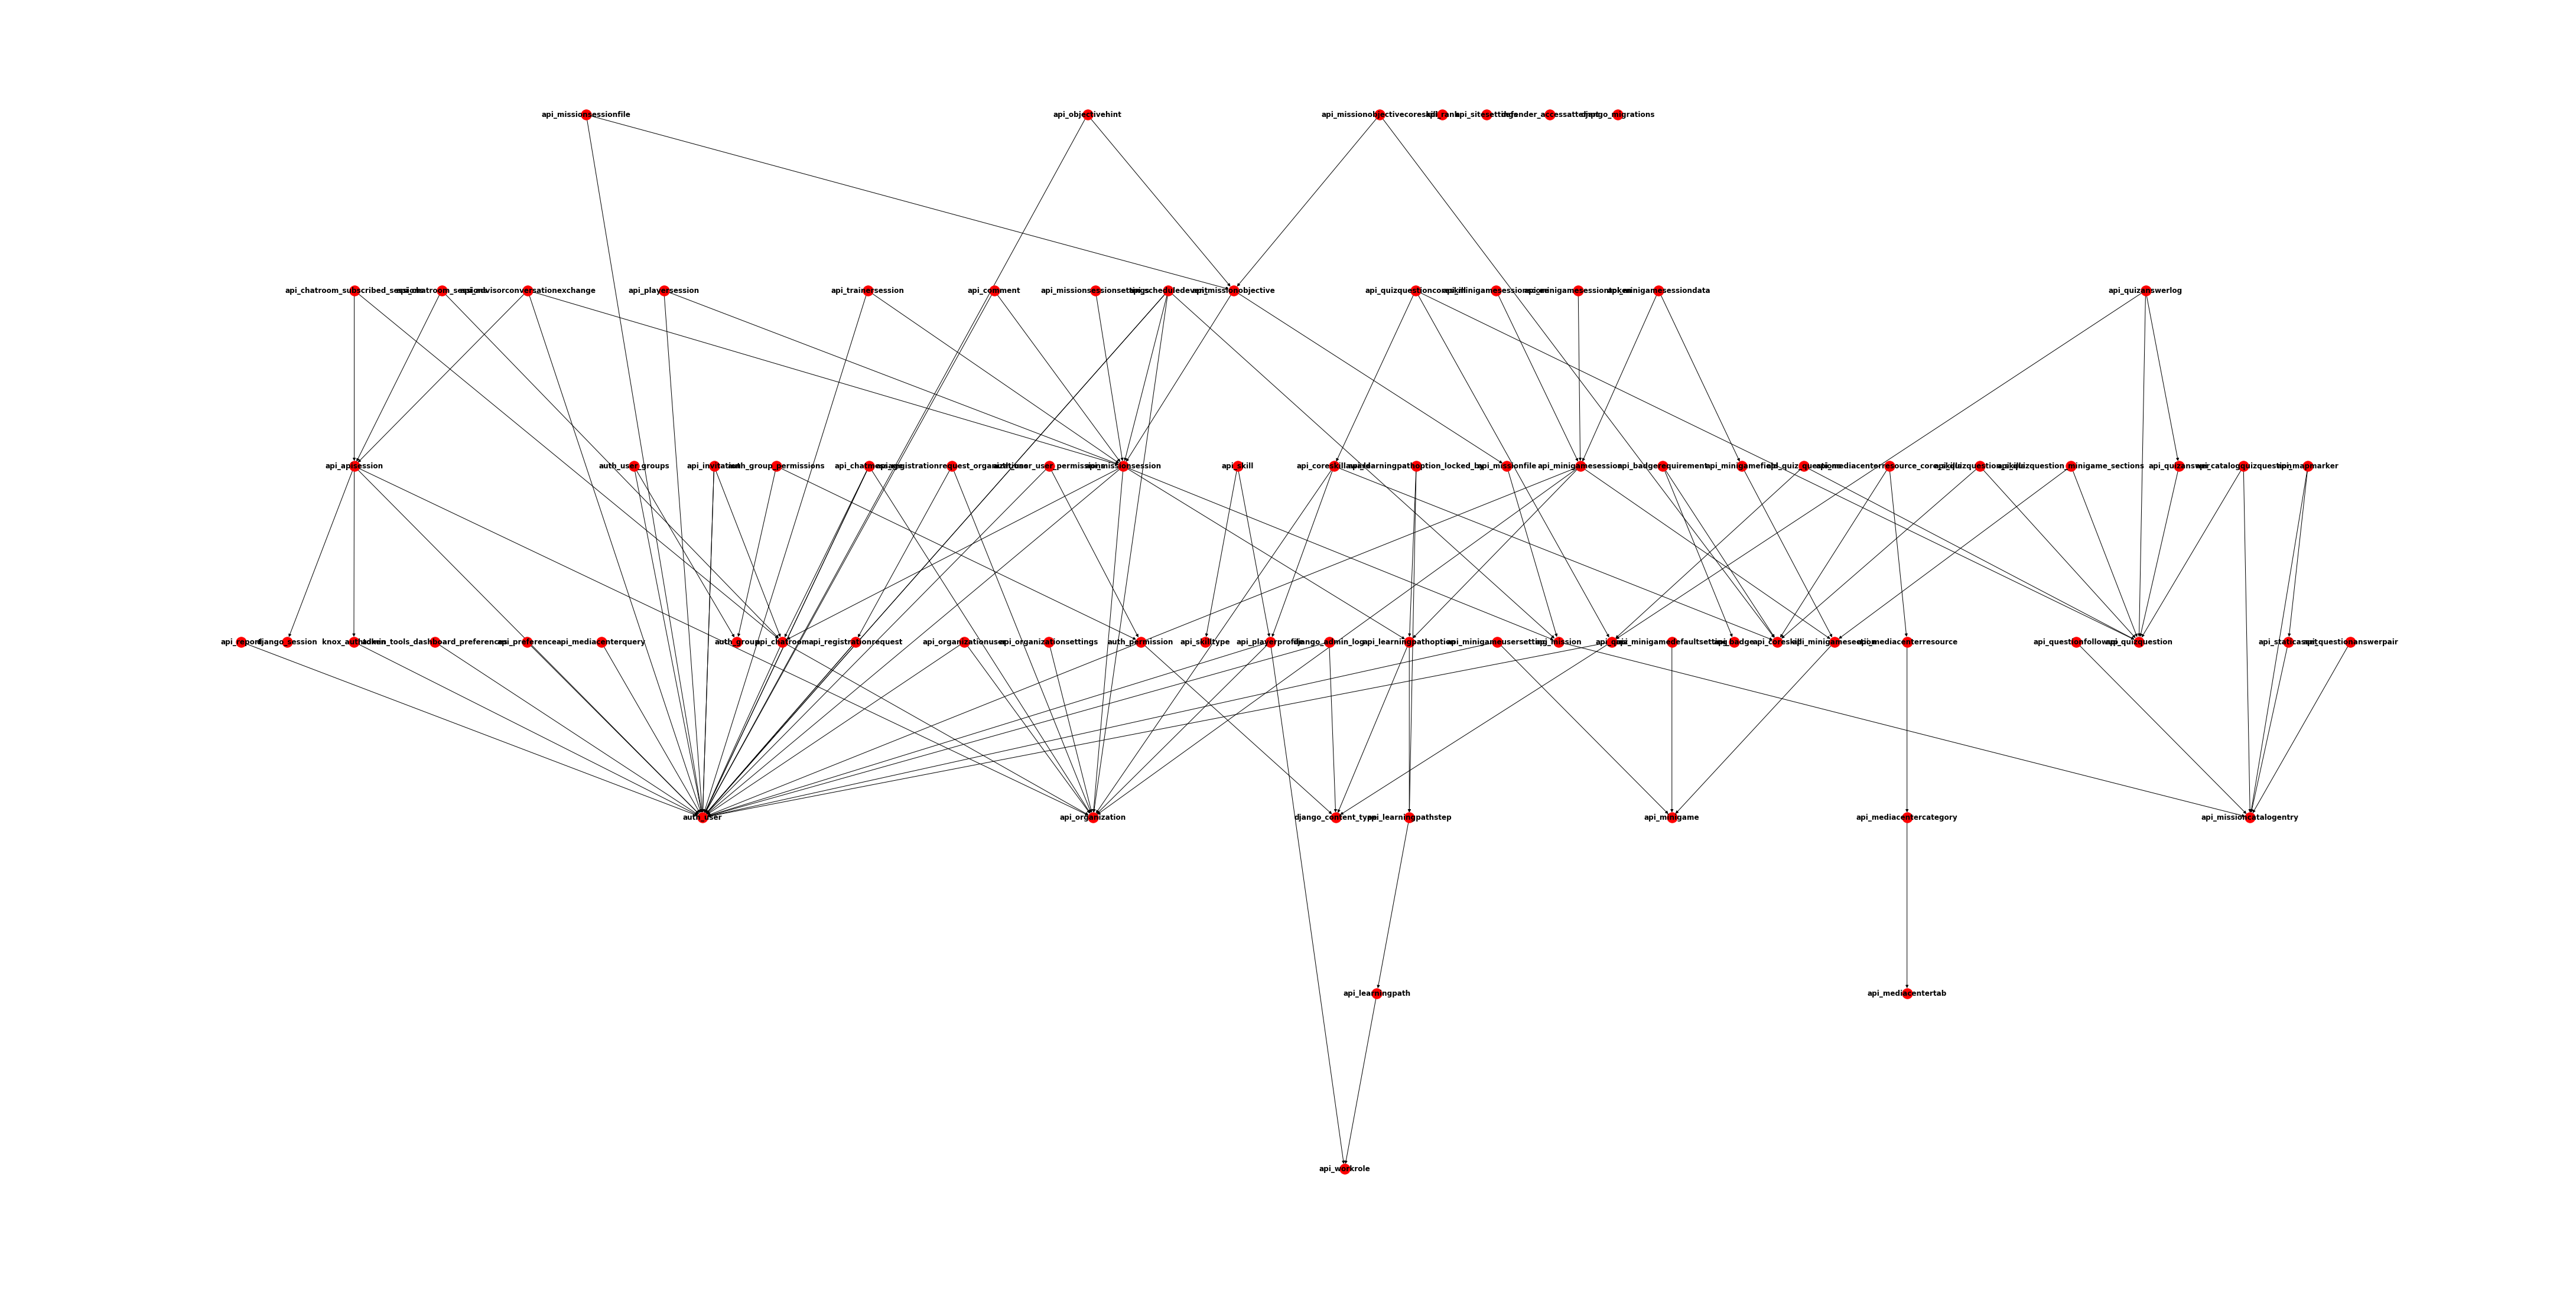

In [28]:
from networkx.drawing.nx_agraph import write_dot, graphviz_layout
plt.figure(1, figsize=(60,30))
# write_dot(G,'all.dot')
pos =graphviz_layout(G, prog='dot')
nx.draw(G, pos,with_labels=True, font_weight='bold', arrows=True)
plt.show()

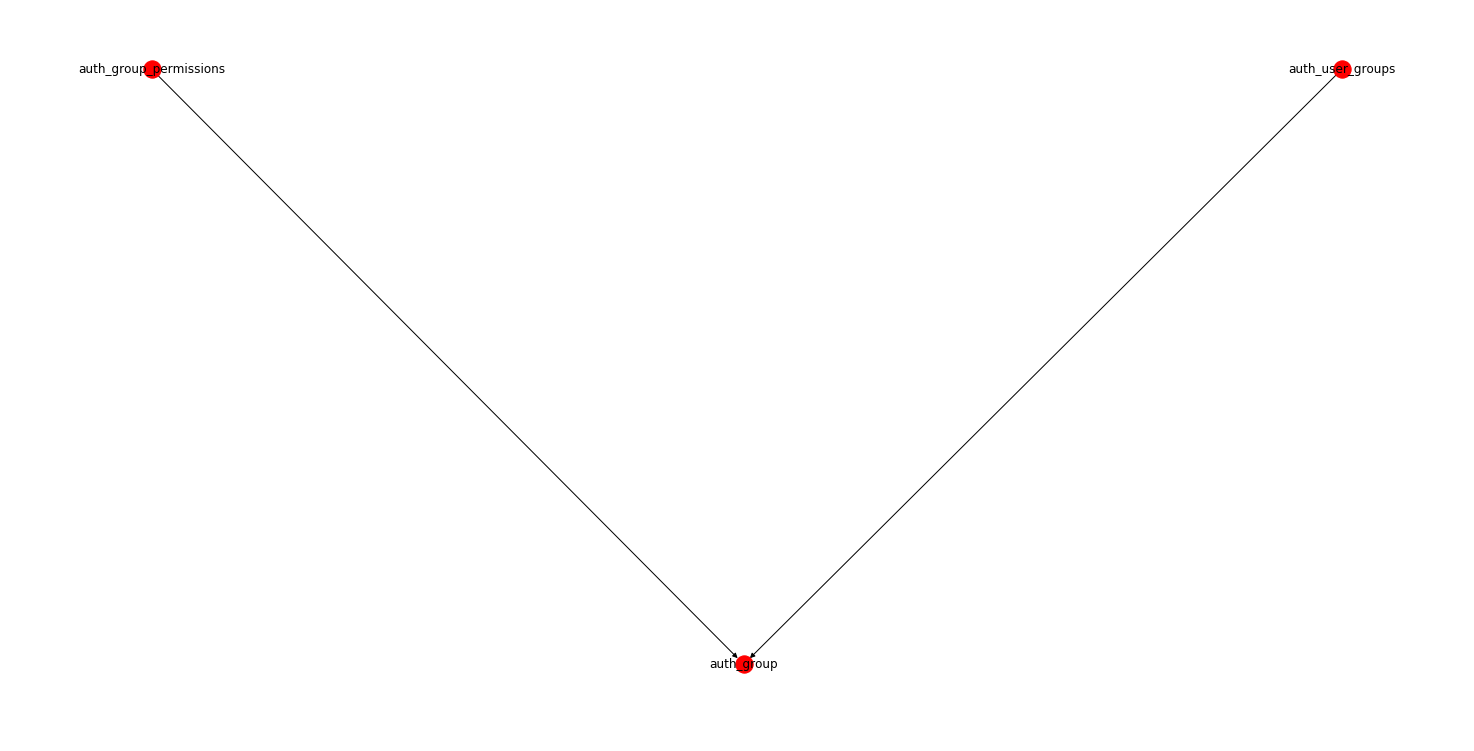

In [29]:
from networkx.drawing.nx_agraph import write_dot, graphviz_layout
plt.figure(1, figsize=(20,10))
g_data = G.subgraph(list(nx.all_neighbors(G, 'auth_group')) + ['auth_group'])
# write_dot(G,'output.dot')
g_data_pos =graphviz_layout(g_data, prog='dot')
nx.draw(g_data, g_data_pos, with_labels=True, arrows=True)
plt.show()

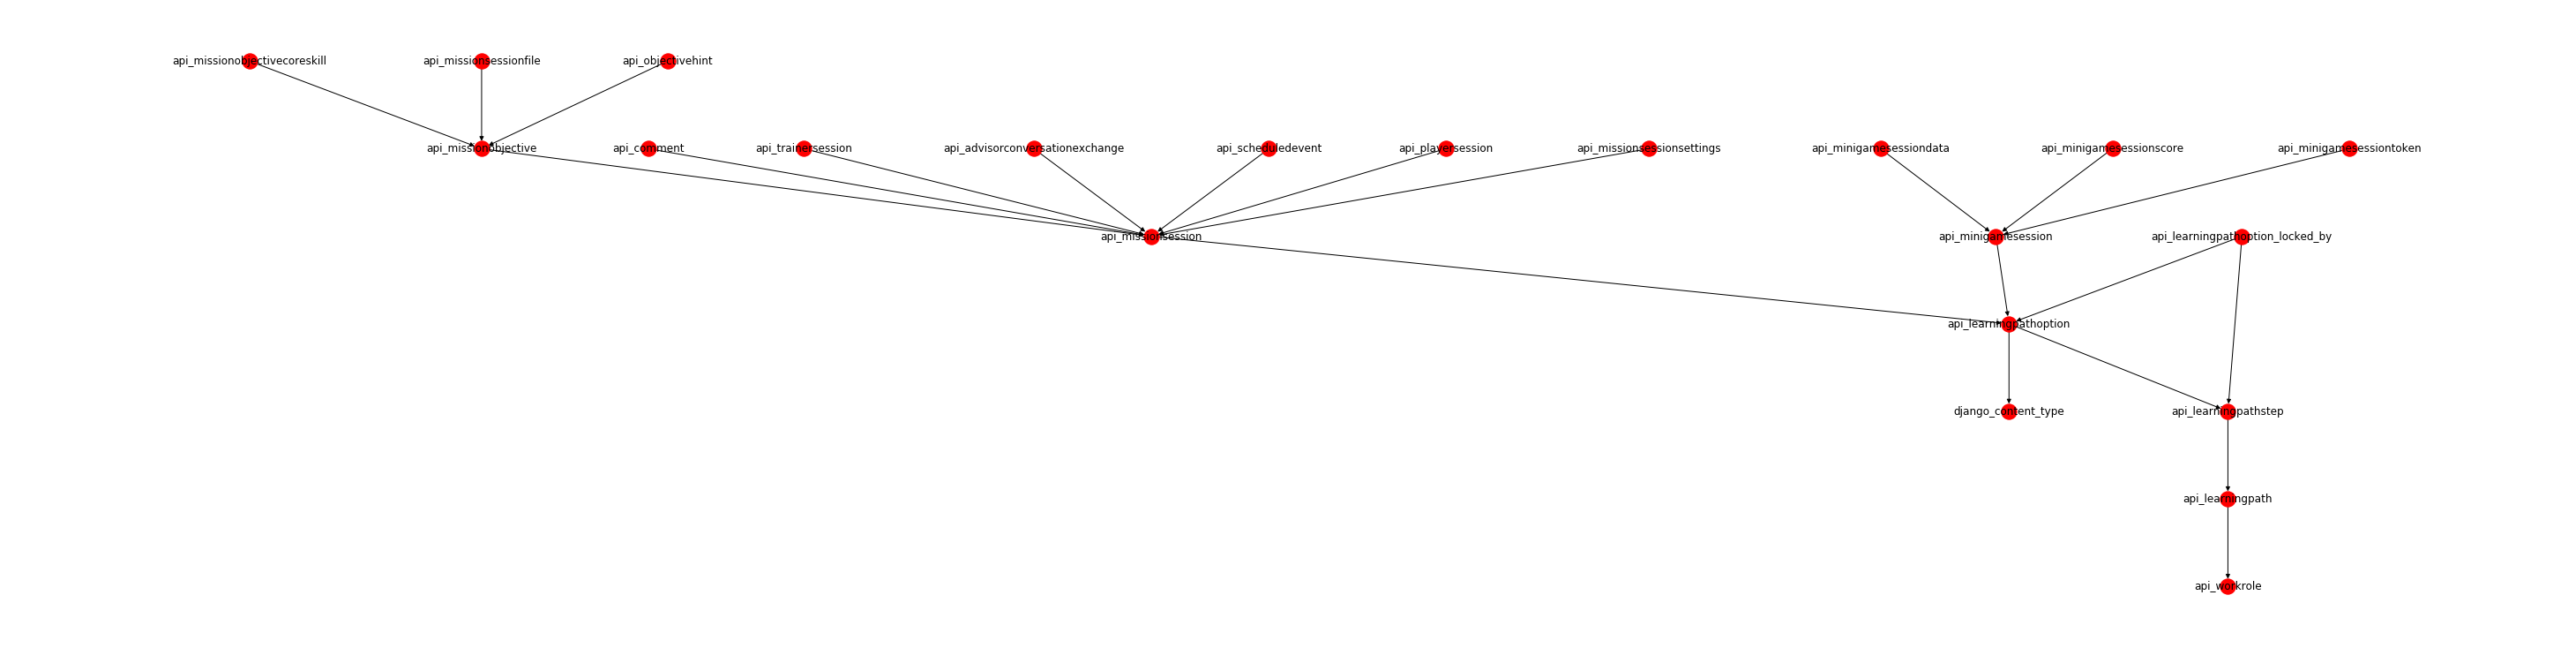

In [31]:
from networkx.drawing.nx_agraph import write_dot, graphviz_layout
node = 'api_learningpathoption'
plt.figure(1, figsize=(40,10))
g_data = G.subgraph(list(nx.dag.descendants(G, node)) + [node] + list(nx.dag.ancestors(G, node)))
# write_dot(G,'output.dot')
g_data_pos =graphviz_layout(g_data, prog='dot')
nx.draw(g_data, g_data_pos, with_labels=True, arrows=True)
plt.show()

In [34]:
from networkx.drawing.nx_agraph import write_dot, graphviz_layout
node = 'django_content_type'
plt.figure(1, figsize=(20,10))
g_data = G.subgraph(list([node]) + G.neighbors(node))
# write_dot(G,'output.dot')
g_data_pos =graphviz_layout(g_data, prog='dot')
nx.draw(g_data, g_data_pos, with_labels=True, arrows=True)
plt.show()

TypeError: can only concatenate list (not "dict_keyiterator") to list

<Figure size 1440x720 with 0 Axes>

In [38]:
#temp 
G.edges[('api_missionobjective', 'api_missionsession', 0)]

{'TABLE_NAME': 'api_missionobjective',
 'COLUMN_NAME': 'missionsession_id',
 'CONSTRAINT_NAME': 'api_missionobjective_missionsession_id_077649f5_fk_api_missionsession_id',
 'REFERENCED_TABLE_NAME': 'api_missionsession',
 'REFERENCED_COLUMN_NAME': 'id'}

In [80]:
# nodes to process first
[n for n in G.nodes if G.in_degree(n) == 0]

['admin_tools_dashboard_preferences',
 'api_advisorconversationexchange',
 'api_badgerequirement',
 'api_catalogquizquestion',
 'api_chatroom_subscribed_sessions',
 'api_chatmessage',
 'api_chatroom_sessions',
 'api_comment',
 'api_invitation',
 'api_learningpathoption_locked_by',
 'api_mapmarker',
 'api_mediacenterresource_core_skills',
 'api_mediacenterquery',
 'api_minigamesessiontoken',
 'api_minigamesessiondata',
 'api_minigameusersetting',
 'api_minigamesessionscore',
 'api_minigamedefaultsetting',
 'api_missionsessionfile',
 'api_missionobjectivecoreskill',
 'api_missionsessionsettings',
 'api_objectivehint',
 'api_organizationsettings',
 'api_organizationuser',
 'api_playersession',
 'api_preference',
 'api_questionfollowup',
 'api_questionanswerpair',
 'api_quizquestion_minigame_sections',
 'api_quizanswerlog',
 'api_quizquestioncoreskill',
 'api_quiz_questions',
 'api_quizquestion_skills',
 'api_rank',
 'api_registrationrequest_organizations',
 'api_report',
 'api_scheduledev

Merge tables need to have keys remapped 

In [32]:
merge_table_root = ['auth_user', 'auth_group','api_missionsession', 'api_organization']
merge_tables = list()
merge_tables.extend(merge_table_root)
for root in merge_table_root:
    merge_tables.extend(list(nx.dag.ancestors(G,root)))
print(len(merge_tables))
sorted(merge_tables)

84


['admin_tools_dashboard_preferences',
 'api_advisorconversationexchange',
 'api_advisorconversationexchange',
 'api_advisorconversationexchange',
 'api_apisession',
 'api_apisession',
 'api_chatmessage',
 'api_chatmessage',
 'api_chatroom',
 'api_chatroom',
 'api_chatroom_sessions',
 'api_chatroom_sessions',
 'api_chatroom_subscribed_sessions',
 'api_chatroom_subscribed_sessions',
 'api_comment',
 'api_comment',
 'api_comment',
 'api_coreskillaward',
 'api_coreskillaward',
 'api_invitation',
 'api_invitation',
 'api_mediacenterquery',
 'api_minigamesession',
 'api_minigamesession',
 'api_minigamesessiondata',
 'api_minigamesessiondata',
 'api_minigamesessionscore',
 'api_minigamesessionscore',
 'api_minigamesessiontoken',
 'api_minigamesessiontoken',
 'api_minigameusersetting',
 'api_missionobjective',
 'api_missionobjective',
 'api_missionobjective',
 'api_missionobjectivecoreskill',
 'api_missionobjectivecoreskill',
 'api_missionobjectivecoreskill',
 'api_missionsession',
 'api_missi

### Data Fixtures

In [76]:
fixture_tables = [x for x in G.nodes if x not in merge_tables]
print(len(fixture_tables))
sorted(fixture_tables)

36


['api_badge',
 'api_badgerequirement',
 'api_catalogquizquestion',
 'api_coreskill',
 'api_learningpath',
 'api_learningpathoption',
 'api_learningpathoption_locked_by',
 'api_learningpathstep',
 'api_mapmarker',
 'api_mediacentercategory',
 'api_mediacenterresource',
 'api_mediacenterresource_core_skills',
 'api_mediacentertab',
 'api_minigame',
 'api_minigamedefaultsetting',
 'api_minigamefield',
 'api_minigamesection',
 'api_mission',
 'api_missioncatalogentry',
 'api_missionfile',
 'api_questionanswerpair',
 'api_questionfollowup',
 'api_quizanswer',
 'api_quizquestion',
 'api_quizquestion_minigame_sections',
 'api_quizquestion_skills',
 'api_rank',
 'api_sitesettings',
 'api_skilltype',
 'api_staticasset',
 'api_workrole',
 'auth_permission',
 'defender_accessattempt',
 'django_content_type',
 'django_migrations',
 'django_session']

In [34]:
# nodes with no edges
list(nx.isolates(G))

['api_rank', 'api_sitesettings', 'defender_accessattempt', 'django_migrations']

### Migration Order

In [35]:
migration_order = list(reversed(list(nx.dag.topological_sort(G))))
migration_order[:5]

['auth_user',
 'admin_tools_dashboard_preferences',
 'knox_authtoken',
 'api_organization',
 'django_session']

In [84]:
migration_order

['auth_user',
 'admin_tools_dashboard_preferences',
 'knox_authtoken',
 'api_organization',
 'django_session',
 'api_apisession',
 'django_content_type',
 'api_workrole',
 'api_learningpath',
 'api_learningpathstep',
 'api_learningpathoption',
 'api_missioncatalogentry',
 'api_mission',
 'api_chatroom',
 'api_missionsession',
 'api_advisorconversationexchange',
 'api_badge',
 'api_coreskill',
 'api_badgerequirement',
 'api_quizquestion',
 'api_catalogquizquestion',
 'api_chatroom_subscribed_sessions',
 'api_chatmessage',
 'api_chatroom_sessions',
 'api_comment',
 'api_invitation',
 'api_learningpathoption_locked_by',
 'api_staticasset',
 'api_mapmarker',
 'api_mediacentertab',
 'api_mediacentercategory',
 'api_mediacenterresource',
 'api_mediacenterresource_core_skills',
 'api_mediacenterquery',
 'api_minigame',
 'api_minigamesection',
 'api_minigamesession',
 'api_minigamesessiontoken',
 'api_minigamefield',
 'api_minigamesessiondata',
 'api_minigameusersetting',
 'api_minigamesession

In [36]:
q = """
CREATE VIEW vw.{tbl} AS 
SELECT
{cols}
FROM dbo.[{tbl}]; GO
"""

In [37]:
from collections import OrderedDict
import json

In [38]:
# this doens't work

# odict = OrderedDict()

# for x, y in edges:
#     if 'api_missionsession' in [x, y]:
#         print(x, y)
#     if 'api_mission' in [x, y]:
#         print(x, y
#              )
#     if y not in odict.keys():
#         odict[y] = {'degree': G.out_degree(y),
#                     'table': y,
#                    'foreign_keys' : [G.edges[e] for e in G.out_edges(y)]}
#     if x not in odict.keys():
#         odict[x] = {'degree': G.out_degree(x),
#                     'table': x,
#                    'foreign_keys' : [G.edges[e] for e in G.out_edges(x)]}
    

In [39]:
# json.dumps(list(odict.values()))

## Create Staging Schema and Copy Data

stage source data into temporary schema

In [40]:
source_db = 'usw01-3-ares_edu'

In [51]:
src_cnx = create_mysql_engine(source_db)

}:;|$Un0@f%%mft@B[|(


In [42]:
pd.read_sql("select 1", con=src_cnx)

,1
0,1


Create staging schema, tables, and copy data over

In [43]:
# check for existing schema
if source_db not in pd.read_sql("select schema_name from information_schema.schemata", con=cnx).schema_name.values:
    # create schema using source database name
    cnx.execute("create schema [{}]".format(source_db), autocommit=True)


In [44]:
src_cnx.driver

'pymysql'

In [ ]:
stg_done = ['admin_tools_dashboard_preferences',
'api_advisorconversationexchange',
'api_apisession',
'api_badgerequirement',
'api_badge',
'api_catalogquizquestion',
'api_chatroom_subscribed_sessions',
'api_chatroom',
'api_chatroom_sessions',
'api_comment',
'api_coreskillaward',
'api_coreskill',
'api_invitation',
'api_learningpathoption_locked_by',
'api_learningpathoption',
'api_learningpath',
'api_learningpathstep',
'api_mapmarker',
'api_mediacentercategory',
'api_mediacenterresource_core_skills',
'api_mediacenterresource',
'api_mediacenterquery',
'api_mediacentertab',
'api_minigamesection',
'api_minigamesessiontoken',
'api_minigame',
'api_minigamesessiondata']

In [ ]:
# iterate through all tables
# stg_done = list()
for table in G.nodes:
    if table in stg_done:
        continue
    if src_cnx.driver == 'pymysql':
        df_source_table = pd.read_sql_table(table, con=src_cnx)
    else:
        df_source_table = pd.read_sql_table(table, con=src_cnx, schema='dbo')
    print(table)
    # add data lineage columns
    df_source_table['source_db'] = source_db
    df_source_table['migration_date'] =  pd.Timestamp.now()
    df_source_table.to_sql(table, con=cnx, schema=source_db, if_exists='replace', index=False, chunksize=5000)
    stg_done.append(table)

## Data Transformation

**Steps**:
1. iterate ordered dict
1. source table from stage
1. all FK's source from target


## Data Migration

keep track of tables that are done.. ideally this is persisted

- stage.id -> id_old
- new_id() -> id_guid 
- identity() -> id
- parameter -> source_db
- pipeline -> migration_date

In [81]:
def generate_simple_select(graph, node, source_schema, target_schema):
    
    query = """ 
INSERT INTO [{target_schema}].[{target_table}] ({insert_columns})
    SELECT
    {columns}
    FROM [{table_schema}].[{table_name}];
"""
    pk = graph.node[node]['PK']
    new_pk = "\t[{0}] as [{0}_old]".format(pk)

    all_columns = graph.node[node]['COLUMNS'].copy()
    
    columns_pk_removed = [x for x in set(all_columns) - set([pk, 'id_guid', 'id_old'])]
    formatted_columns = ["\t[{}]".format(x) for x in columns_pk_removed]
    columns_string = ',\n'.join([new_pk] + formatted_columns)

    insert_columns = ', '.join([ '[%s]' % x for x in ['id_old'] + columns_pk_removed])
    return query.format(columns=columns_string,
                        insert_columns=insert_columns,
                 table_schema=source_schema,
                 table_name=node,
                       target_schema=target_schema,
                       target_table=node)

print(generate_simple_select(G, 'api_coreskill', 'ares_test', 'dbo'))

 
INSERT INTO [dbo].[api_coreskill] ([id_old], [description])
    SELECT
    	[label] as [label_old],
	[description]
    FROM [ares_test].[api_coreskill];



In [83]:
def generate_join_clause(G, edge, referenced_schema, referenced_alias, source_db, remap_suffix='_old'):
    data = G.edges[edge]
    source_column = data['COLUMN_NAME']
    referenced_table = data['REFERENCED_TABLE_NAME']
    referenced_column = data['REFERENCED_COLUMN_NAME']
    
    # join on natural key (referenced key) on stage = id_old in new_schema
    join = """
LEFT JOIN [{referenced_schema}].[{referenced_table}] as [{referenced_alias}]
    ON [{referenced_alias}].[{referenced_column}{remap_suffix}] = s.[{source_column}]
""".format(
           source_column=source_column, 
           referenced_schema=referenced_schema, 
           referenced_table=referenced_table, 
           referenced_alias=referenced_alias, 
           referenced_column=referenced_column,
            remap_suffix=remap_suffix)

    # id is new surrogate key generated on insert
    column = '[{referenced_alias}].[{referenced_column}] as [{source_column}]'.format(referenced_alias=referenced_alias, 
                                                                                      referenced_column=referenced_column,
                                                                                      source_column=source_column)
    # generate where condition
    clause = "[{referenced_alias}].[source_db] = '{source_db}'".format(referenced_alias=referenced_alias, 
                                                                      source_db=source_db)
    return (column, join.strip(), clause)

print(*generate_join_clause(G, ('api_missionsession', 'auth_user', 0), 'dbo', 't0', 'foo'))

[t0].[id] as [owner_id] LEFT JOIN [dbo].[auth_user] as [t0]
    ON [t0].[id_old] = s.[owner_id] [t0].[source_db] = 'foo'


In [72]:
def generate_select_with_fk(graph, node, source_schema, target_schema):
    
    query = """
INSERT INTO [{target_schema}].[{target_table}] ({insert_columns})
    SELECT
    {columns}
    FROM [{table_schema}].[{table_name}] s
    {joins}
    WHERE {where};
    """
    pk = graph.node[node]['PK']
    
    new_pk = "\ts.[{0}] as [{0}_old]".format(pk)

    original_columns = ['{}'.format(x) for x in graph.node[node]['COLUMNS'].copy()]
    
    
    # get FKs
    edges = list(graph.out_edges(node))
    joins = list()
    clauses = list()
    columns_to_remove = list()
    fk_columns = list()
    columns_skipped = list()
    
    done = dict()
    i = 0
    for edge in edges:
        
        #handle multiple edges between same nodes
        if edge not in done.keys():
            done[edge] = 0
        else:
            done[edge] += 1
            
        edge_data = graph.edges[(*edge, done[edge])]
        
        
        if edge_data['REFERENCED_COLUMN_NAME'] != 'id':
#             columns_skipped.append(edge_data['COLUMN_NAME'])
#             columns_to_remove.append(edge_data['COLUMN_NAME'])
            remap_suffix = ''
        else:
            remap_suffix = '_old'
        fk, join, clause = generate_join_clause(G=G, edge=(*edge, done[edge]),
                                        referenced_schema=target_schema,
                                        referenced_alias='f' + str(i),
                                        remap_suffix=remap_suffix,
                                        source_db=source_schema)
        joins.append(join)
        fk_columns.append(fk)
        clauses.append(clause)
        columns_to_remove.append(edge_data['COLUMN_NAME'])
        
        i += 1
    non_insert_columns = [pk, 'id_guid', 'id_old']
    pruned_columns = [x for x in original_columns if x not in columns_to_remove + non_insert_columns ]
    formatted_columns = ["\t{0}.[{1}]".format('s', x) for x in pruned_columns]
    all_columns = [new_pk] + formatted_columns + ["\t{}".format(x) for x in fk_columns]
    columns_string = ',\n'.join(all_columns)
    
    insert_columns = ', '.join(['[%s]' % x for x in ['id_old'] + pruned_columns + columns_to_remove if x not in columns_skipped])
    
    where_clause = '\n\tAND '.join(clauses)
    
    return query.format(columns=columns_string,
                        insert_columns=insert_columns,
                     table_schema=source_schema,
                     table_name=node,
                       target_schema=target_schema,
                       target_table=node,
                       joins='\n'.join(joins),
                       where=where_clause)


print(generate_select_with_fk(G, 'api_badgerequirement', source_db, 'dbo'))


INSERT INTO [dbo].[api_badgerequirement] ([id_old], [source_db], [migration_date], [skill_source], [points], [badge_id], [core_skill_id])
    SELECT
    	s.[id] as [id_old],
	s.[source_db],
	s.[migration_date],
	s.[skill_source],
	s.[points],
	[f0].[id] as [badge_id],
	[f1].[label] as [core_skill_id]
    FROM [usw01-3-ares_edu].[api_badgerequirement] s
    LEFT JOIN [dbo].[api_badge] as [f0]
    ON [f0].[id_old] = s.[badge_id]
LEFT JOIN [dbo].[api_coreskill] as [f1]
    ON [f1].[label] = s.[core_skill_id]
    WHERE [f0].[source_db] = 'usw01-3-ares_edu'
	AND [f1].[source_db] = 'usw01-3-ares_edu';
    


In [ ]:
def simple_insert(cnx, table, source_schema, target_schema):
    df_source = pd.read_sql_table(table, con=cnx, schema=source_schema)
    df_target = pd.read_sql_table(table, con=cnx, schema=target_schema)
    df_source[df_target.columns].to_sql(table, con=cnx, schema=target_schema, index=False,chunksize=500, if_exists='append')

In [ ]:
# handle tables where pk != id
done = list()
source_schema = source_db
target_schema = 'dbo'
skipped = list()
for table in migration_order:
        
    if G.out_degree(table) == 0 and G.nodes[table]['PK'] != 'id':
        print(table)
#         df_source = pd.read_sql_table(table, con=cnx, schema=source_schema)
#         df_target = pd.read_sql_table(table, con=cnx, schema=target_schema)
#         df_source[df_target.columns].to_sql(table, con=cnx, schema=target_schema, index=False,chunksize=500, if_exists='append')
        simple_insert(cnx, table, source_schema, target_schema)
        done.append(table)



In [ ]:
with open('migration_order.json') as f:
    raw_exclude = json.load(f)

exclusion_list = [x['table'] for x in raw_exclude if x.get('exclude') == True]

In [ ]:
# done = list()
source_schema = source_db
target_schema = 'dbo'
skipped = list()
table_to_skip = ['api']
for table in migration_order:
#     if  table in exclusion_list:
#         continue
    if table in done:
        print('Skipping %s' % table)
        skipped.append(table)
        continue
        
    
    if G.out_degree(table) == 0:
        insert_query = generate_simple_select(G, table, source_schema, target_schema)
    elif G.nodes[table]['PK'] != 'id':
        simple_insert(cnx, table, source_schema, target_schema)
    else:
        insert_query = generate_select_with_fk(G, table, source_schema, target_schema)
    print(table)
    cnx.execute(insert_query, autocommit=True)
    done.append(table)

